In [1]:
RANDOM_STATE = 101
no_dummies = False # 'no dummies' in DATA_DETAIL
VERSION = '09'

AUTOENCODE_EPOCHS = 400
AUTOENCODE_EPOCHS = 80
#AUTOENCODE_EPOCHS = 10

In [2]:
import sys
import os
import json

module_path = os.path.abspath(os.path.join('..', '..', '..'))
if module_path not in sys.path:
    #sys.path.append(module_path+"\\zfunctions")
    sys.path.append(module_path)

#with open('../../z_envs/_envs.json') as f:
#    env_vars = json.loads(f.read())

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

if "JPY_PARENT_PID" in os.environ:
    is_jupyter = True
else:
    is_jupyter = False



if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_b__get_the_data_20221116 import set_csv_directory
    set_csv_directory('final_split')
else:
    cloud_run = True

from functions_0__common_20221116 import get_columns
from functions_b__get_the_data_20221116 import get_combined_dataset, get_source_dataframe
from functions_d1__prepare_cleanse_data_20221116 import tidy_dataset
from functions_d2__transform_enrich_data_20221116 import preprocess, feature_engineer
from functions_d3__prepare_store_data_20221116 import create_train_test_data
from functions_e__train_model_20221116 import get_chosen_model, make_modelling_pipeline, get_cv_params, fit_model_with_cross_validation, get_hyperparameters
from functions_f_evaluate_model_20221116 import get_best_estimator_average_time, get_results, update_results

#print(env_vars)

In [3]:
columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)
LABEL = 'Price'

In [4]:
df, retrieval_type = get_source_dataframe(cloud_run, VERSION, folder_prefix='../../../', row_limit=None)
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))


    df = df[columns]

loaded data from ../../../data/final/df_listings_v09.csv


In [5]:
X_train_orig, X_test_orig, y_train_orig, y_test_orig, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True,
    no_dummies=no_dummies
)

#print(X_train[0])
print(df.shape)
print(X_train_orig.shape, X_test_orig.shape, y_train_orig.shape, y_test_orig.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)



(46871, 19)
(39714, 21) (4413, 21) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/80
2483/2483 - 9s - loss: 0.0246 - val_loss: 0.0044 - 9s/epoch - 4ms/step
Epoch 2/80
2483/2483 - 8s - loss: 0.0075 - val_loss: 0.0023 - 8s/epoch - 3ms/step
Epoch 3/80
2483/2483 - 8s - loss: 0.0056 - val_loss: 0.0022 - 8s/epoch - 3ms/step
Epoch 4/80
2483/2483 - 8s - loss: 0.0047 - val_loss: 0.0013 - 8s/epoch - 3ms/step
Epoch 5/80
2483/2483 - 8s - loss: 0.0041 - val_loss: 0.0013 - 8s/epoch - 3ms/step
Epoch 6/80
2483/2483 - 8s - loss: 0.0037 - val_loss: 0.0010 - 8s/epoch - 3ms/step
Epoch 7/80
2483/2483 - 8s - loss: 0.0035 - val_loss: 0.0011 - 8s/epoch - 3ms/step
Epoch 8/80
2483/2483 - 8s - loss: 0.0032 - val_loss: 8.6876e-04 - 8s/epoch - 3ms/step
Epoch 9/80
2483/2483 - 8s - loss: 0.0030 - val_loss: 8.1502e-04 - 8s/epoch - 3ms/step
Epoch 10/80
2483/2483 - 8s - loss: 0.0030 - val_loss: 6.6956e-04 - 8s/epoch - 3ms/step
Epoch

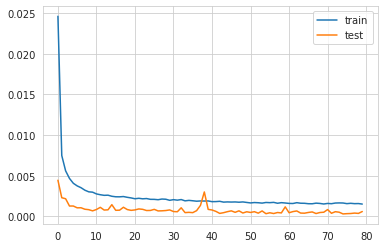

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [6]:
# train autoencoder for regression with no compression in the bottleneck layer
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import ReLU
from keras.layers import BatchNormalization
from keras.utils import plot_model
from matplotlib import pyplot
# define dataset
#X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)
# number of input columns
n_inputs = X_train_orig.shape[1]
# split into train test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train_orig)
X_train = t.transform(X_train_orig)
X_test = t.transform(X_test_orig)
# define encoder
visible = Input(shape=(n_inputs,))
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = ReLU()(e)
# define bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)
# define decoder
d = Dense(n_inputs*2)(bottleneck)
d = BatchNormalization()(d)
d = ReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
plot_model(model, 'autoencoder.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
#history = model.fit(X_train, X_train, epochs=400, batch_size=16, verbose=2, validation_data=(X_test,X_test))
history = model.fit(X_train, X_train, epochs=AUTOENCODE_EPOCHS, batch_size=16, verbose=2, validation_data=(X_test,X_test))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder.png', show_shapes=True)
# save the encoder to file
encoder.save(f'autoencoder_encoder_v{VERSION}.h5')

In [7]:
if False:
    y_train = y_train.ravel()
    y_test = y_test.ravel()

    # support vector regression performance with encoded input
    from sklearn.datasets import make_regression
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    from sklearn.svm import SVR
    from sklearn.metrics import mean_absolute_error
    from keras.models import load_model
    # define dataset
    #???X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)
    # split into train test sets
    #???X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
    print("Before:")
    print(y_train[0:5])
    print(y_test[0:5])
    # reshape target variables so that we can transform them
    y_train = y_train.reshape((len(y_train), 1))
    y_test = y_test.reshape((len(y_test), 1))
    # scale input data
    trans_in = MinMaxScaler()
    trans_in.fit(X_train)
    X_train = trans_in.transform(X_train)
    X_test = trans_in.transform(X_test)
    # scale output data
    trans_out = MinMaxScaler()
    trans_out.fit(y_train)
    y_train = trans_out.transform(y_train)
    y_test = trans_out.transform(y_test)
    print("Scaled:")
    print(y_train[0:5])
    print(y_test[0:5])
    # load the model from file
    ###encoder = load_model('encoder.h5')
    encoder = load_model(f'autoencoder_encoder_v{VERSION}.h5')
    # encode the train data
    X_train_encode = encoder.predict(X_train)
    # encode the test data
    X_test_encode = encoder.predict(X_test)
    # define model
    model = SVR()
    # fit model on the training dataset
    model.fit(X_train_encode, y_train)
    # make prediction on test set
    y_pred = model.predict(X_test_encode)
    # invert transforms so we can calculate errors
    y_pred = y_pred.reshape((len(y_pred), 1))
    y_pred = trans_out.inverse_transform(y_pred)
    y_test = trans_out.inverse_transform(y_test)
    # calculate error
    score = mean_absolute_error(y_test, y_pred)
    print(score)


In [9]:
from sklearn.svm import SVR
from keras.saving.save import load_model

# load the model from file
encoder = load_model(f'autoencoder_encoder_v{VERSION}.h5')

# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)

138/138 [==============================] - 0s 1ms/step


In [13]:
X_train_orig[0:3]

array([[ 3.00000000e+00,  3.00000000e+00,  3.16613257e-01,
         5.14597600e+01,  1.29390000e-01,  3.99600000e-02,
         2.33810000e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  5.30933747e-01,
         5.15326700e+01,  7.54000000e-02,  3.29500000e-02,
         1.79820000e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00],
       [ 1.00000000e+00,  1.00000000e+00,  2.85509374e-01,
         5.15140500e+01, -6.13600000e-02,  1.43300000e-02,
         4.30600000e-02,  0.00000000e+00,  0.00000000e

In [14]:
X_train[0:3]

array([[0.33333333, 0.5       , 0.04398811, 0.41947629, 0.80673924,
        0.19840817, 0.59380921, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.07376436, 0.60891786, 0.73733372,
        0.16360233, 0.45669035, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.03966675, 0.56053764, 0.56152525,
        0.07115088, 0.10935984, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        ]])

In [15]:
X_test_encode[0:3]

array([[-2.26041102e+00, -8.69177878e-01,  6.60994768e-01,
         1.59839284e+00,  9.87535536e-01, -2.55913162e+00,
         2.35561490e-01,  1.89207757e+00, -1.06529915e+00,
        -9.36045721e-02,  1.03950284e-01,  3.46554875e-01,
        -1.07024336e+00,  3.40605617e+00, -2.41133714e+00,
         1.39954960e+00,  3.79644823e+00,  1.43618393e+00,
         1.74850404e+00, -5.26522636e-01, -1.20411623e+00],
       [-1.54829359e+00, -1.25590146e+00,  1.45944715e+00,
         5.62467456e-01, -3.56398493e-01, -1.98813677e+00,
         4.11643177e-01,  2.19792747e+00, -1.48871350e+00,
        -1.41852748e+00, -1.68730125e-01,  5.52630536e-02,
        -1.52943957e+00,  4.67729139e+00, -2.91354561e+00,
        -3.51322383e-01,  3.24847221e+00,  2.83924913e+00,
         1.93755770e+00, -9.54187155e-01, -3.91849488e-01],
       [-1.42497587e+00, -1.44458437e+00, -4.15859632e-02,
         1.21072710e+00,  1.36743200e+00, -3.66671848e+00,
         1.52969058e-03,  1.32232368e+00, -2.17481947e

In [16]:
y_train = y_train_orig
y_test = y_test_orig

In [17]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor

# define model
#model = SVR()
#model = LinearRegression()
model = KNeighborsRegressor()

# fit model on the training dataset
model.fit(X_train_encode, y_train)
# make prediction on test set

KNeighborsRegressor()

In [18]:
y_pred = model.predict(X_test_encode)
y_pred_orig = y_pred

In [19]:
# invert transforms so we can calculate errors
y_pred = y_pred.reshape((len(y_pred), 1))


#trans_out = MinMaxScaler()
#trans_out.fit(y_train)

#y_pred = trans_out.inverse_transform(y_pred)
#??? y_test = trans_out.inverse_transform(y_test)
# calculate error

In [20]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
mae_score = mean_absolute_error(y_test, y_pred)
score = r2_score(y_test, y_pred)
print(mae_score)
print(score)

51945.6956265579
0.5930633563104948


In [21]:
print(y_test[0], y_pred[0])


[400000.] [385000.]


In [22]:
import numpy as np

print("Score (mean absolute error):", mean_absolute_error(y_test, y_pred), "\n")
compare_np = np.hstack((y_test, y_pred))
compare_df = pd.DataFrame(compare_np, columns=['actual', 'predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100

compare_df

Score (mean absolute error): 51945.6956265579 



,actual,predicted,diff 1 %,diff 2 %
0,400000.0,385000.0,3.750000,3.896104
1,369950.0,489980.0,32.444925,24.496918
2,350000.0,348000.0,0.571429,0.574713
3,549000.0,530000.0,3.460838,3.584906
4,495000.0,519000.0,4.848485,4.624277
...,...,...,...,...
4408,475000.0,535990.0,12.840000,11.378944
4409,575000.0,512000.0,10.956522,12.304688
4410,400000.0,441000.0,10.250000,9.297052
4411,450000.0,589990.0,31.108889,23.727521


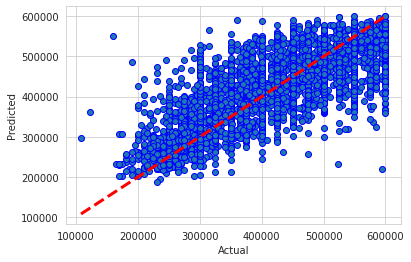

In [23]:
import matplotlib.pyplot as plt
best_model_fig, best_model_ax = plt.subplots()
best_model_ax.scatter(y_test, y_pred, edgecolors=(0, 0, 1))
best_model_ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
best_model_ax.set_ylabel('Predicted')
best_model_ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')

plt.show()